<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Homework 4</div>

$\textbf{Auteur}$ : Adel Nabli


$\textbf{ID}$: 20121744

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
X_train = np.loadtxt('EMGaussian.train')
X_test = np.loadtxt('EMGaussian.test')

# Homework 3

## K-means

The metric to minimize here is the distortion $J(\mu, z) = \sum_{i=1}^N \sum_{k=1}^K z_i^k || x_i - \mu_k ||^2$

____________________________________________________________________

$\textbf{ALGORITHM:}$

* $\textbf{Parameters}$: number of cluters K and tolerance $\epsilon$
* $\textbf{Initialization}$: create random centroïdes
* $\textbf{While}\; \; |J(\mu_{t+1}, z_{t+1}) - J(\mu_t, z_t)| > \epsilon, \; \textbf{do}$:

$\hspace{2cm}$ - $\textbf{for} \; i =1,...,n$, find the closest centroïde $\mu_t^k$ to $x_i$ and assign $x_i$ to the cluster $k$ ($z_i^k=1$)

$\hspace{2cm}$ - $\textbf{Compute}$ the new centroïdes $\mu_{t+1}^k = \dfrac{\sum_i z_i^k x_i}{\sum_i z_i^k}$

_____________________________________________________________________

* We will initialize $\mu$ uniformely on the window given by the data
* $\mu_t = \begin{pmatrix} \mu_t^1 \\ \vdots \\ \mu_t^K \end{pmatrix}$, each row being a 2 dimensional vector
* $Z \in \mathbb{R}^{N \times K}$ is the matrix which contains the clusters of each data point: each row is attributed to a data point and contains its cluster (via a one-hot encoding)

In [3]:
def compute_J(X, mu, Z):
    
    """Compute and returns the distortion for a given set of centroides and X, and z"""
    
    j = 0
    
    for i in range(len(X)):
        
        j += np.linalg.norm(X[i] - Z[i].dot(mu))**2
    
    return(j)

In [4]:
def compute_Z(X, mu):
    
    """Compute and returns the matrix Z for a given dataset and set of centroïdes"""
    
    Z = np.zeros((len(X), len(mu)))
    
    for i in range(len(X)):
        
        distance_min = math.inf
        cluster = None
        
        for k in range(len(mu)):
            
            distance = np.linalg.norm(X[i]-mu[k])
            
            if distance < distance_min:
                
                distance_min = distance
                cluster = k
        
        Z[i][cluster] = 1
    
    return(Z)      

In [5]:
def compute_mu(X, Z):
    
    """Compute and returns the vector mu for a given dataset and Z"""
    
    sum_z = np.sum(Z, axis=0)
    
    return((X.T.dot(Z)/sum_z).T)

In [6]:
def K_means(X, K, epsilon):
    
    # Compute some values usefull to know how to initialize the centroides
    
    max_x, max_y = np.max(X[:, 0]), np.max(X[:, 1])
    min_x, min_y = np.min(X[:, 0]), np.min(X[:, 1])
    scale_x, scale_y = max_x - min_x, max_y - min_y
    
    # Initialize the vector mu and build it
    
    mu0_x = scale_x*np.random.random(K) + min_x
    mu0_y = scale_y*np.random.random(K) + min_y
    
    mu_t = []
    
    for k in range(K):
        
        mu_k = [mu0_x[k], mu0_y[k]]
        mu_t.append(mu_k)
    
    # We apply the algorithm

    difference = math.inf
    Z_t = compute_Z(X, mu_t)
    J_t = compute_J(X, mu_t, Z_t)
    
    while difference > epsilon:
        
        Z_t = compute_Z(X, mu_t)
        mu_t = compute_mu(X, Z_t)
        J_t1 = compute_J(X, mu_t, Z_t)
        difference = np.abs(J_t1 - J_t)
        J_t = J_t1
    
    return(mu_t, Z_t, J_t)

In [7]:
def plot(X, mu, Z, J):
    
    """plot the data to visualize the results of the k-means algorithm"""
    
    colors = ['b', 'g', 'c', 'm']
    colums = np.array([0, 1, 2, 3])
    
    for i in range(len(X)):
        
        plt.scatter(X_train[i, 0], X_train[i, 1], marker='x', color = colors[int(colums.dot(Z[i]))])
    
    plt.scatter(mu[:, 0], mu[:, 1], marker ='o', color='k')
    plt.title('Results of the k-means algorithm, $J=$'+ str(np.round(J, 2)))
    plt.show()

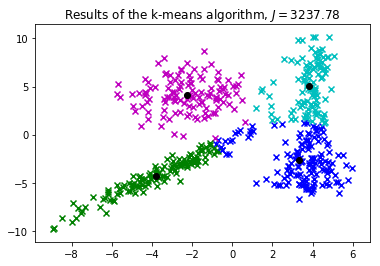

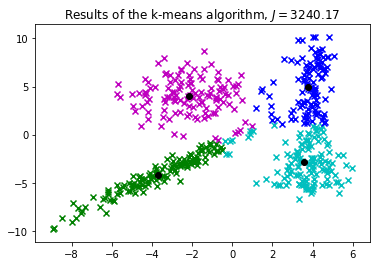

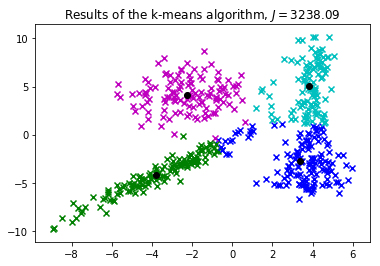

In [8]:
mu, Z, J = K_means(X_train, 4, 0.01)
plot(X_train, mu, Z, J)

mu, Z, J = K_means(X_train, 4, 0.01)
plot(X_train, mu, Z, J)

mu, Z, J = K_means(X_train, 4, 0.01)
plot(X_train, mu, Z, J)

## E-M Algorithm

Let $z$ be the hidden variables and $x$ be the observed data. We make the assumption that the $x_i$, $i \in \{1, ..., N\}$ are i.i.d. We suppose that the $z_i \sim \mathcal{M}(\pi_1,...\pi_K)$ and $(x_i \; | \; z_i=k) \sim \mathcal{N} (\mu_k, \Sigma_k)$.
We define $\theta = (\pi, \mu, \Sigma)$.

We want to maximize the log-likelihood  $\log p_{\theta}(x) = \sum_{i=1}^N \log \sum_{z_i} p_{\theta}(x_i, z_i) = \sum_{i=1}^N \log \sum_{k=1}^K \pi_k \mathcal{N}(x_i \; | \; \mu_k, \Sigma_k)$.

For that, we use the $\textit{E-M algorithm}$:

____________________________________________________

$\textbf{ALGORITHM}:$

* $\textbf{Parameters}$: tolerance $\epsilon$
* $\textbf{Initialize}$ the parameters in $\theta$ using the results given by the $\textit{k-means algorithm}$ ($\mu^0 = \mu_{k-means}$ and $\tau^0 = Z_{k-means}$)
* $\textbf{While} \; \;| \log p_{\theta^{t+1}}(x) - \log p_{\theta^{t}}(x) | \; > \; \epsilon$, $\textbf{do}$:

$\hspace{2cm}$ - $\textbf{Compute}$ $\forall i \in \{1,...N\}, \; \forall k \in \{1,...K\}$ the $p_{\theta^t}(z_i = k \;|\; x_i) = \dfrac{\pi_k \mathcal{N}(x_i \; | \; \mu_k^t, \Sigma_k^t)}{\sum_k \pi_k \mathcal{N}(x_i \; | \; \mu_k^t, \Sigma_k^t)} = \tau_i^k(\theta^t)$

$\hspace{2cm}$ - $\textbf{Compute}$ $ \forall k \in \{1,...K\}$ the new values:

$\hspace{2cm}$ $\pi_k^{t+1} = \dfrac{\sum_{i=1}^N \tau_i^k}{N} \quad , \quad \mu_k^{t+1} = \dfrac{\sum_{i=1}^N \tau_i^k x_i}{\sum_{i=1}^N \tau_i^k} \quad , \quad \Sigma_k^{t+1} = \dfrac{\sum_{i=1}^N \tau_i^k (x_i - \mu_k^{t+1})(x_i - \mu_k^{t+1})^T}{\sum_{i=1}^N \tau_i^k}$

_____________________________________________________

* If we are considering the case $\Sigma_k = \sigma_k^2 \mathbb{I}_d$, we have $\sigma_k^{2 \; t+1} = \dfrac{\sum_{i=1}^N \tau_i^k (x_i - \mu_k^{t+1})^T(x_i - \mu_k^{t+1})}{d\sum_{i=1}^N \tau_i^k}$

* We recall that $\mathcal{N}(x_i \; | \; \mu, \Sigma) = \dfrac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\Big( - \dfrac{(x_i-\mu)^T \Sigma^{-1}(x_i-\mu)}{2} \Big)$.

* We will work with matrices to store the values of the parameters for every $k$. Thus, $\tau \in \mathbb{R}^{N \times K}$, $\pi \in \mathbb{R}^K$, $\mu \in \mathbb{R}^{K \times d}$, $\Sigma \in \mathbb{R}^{K \times d \times d}$ (and $d=2$ here).

In [9]:
def compute_log_likelihood(X, pi, mu, Sigma):
    
    """Compute and returns the log likelihood"""
    
    L = 0
    
    for i in range(len(X)):
        
        Sum = 0
        
        for k in range(len(pi)):
            
            Sum += (pi[k]/(2*np.pi*np.sqrt(linalg.det(Sigma[k])))) * np.exp(-0.5*(X[i] - mu[k]).T.dot(linalg.inv(Sigma[k])).dot(X[i]-mu[k]))
        
        L += np.log(Sum)
            
    return(L)

In [10]:
def compute_tau(X, pi, mu, Sigma):
    
    """Compute and returns the matrix tau"""
    
    tau = np.zeros((len(X), len(pi)))
    
    for i in range(len(X)):
        
        Sum = 0
        
        for k in range(len(pi)):
            
            tau[i, k ] = (pi[k]/(2*np.pi*np.sqrt(linalg.det(Sigma[k])))) * np.exp(-0.5*(X[i] - mu[k]).T.dot(linalg.inv(Sigma[k])).dot(X[i]-mu[k]))
            Sum += tau[i, k]
        
        tau[i, :] *= 1/Sum
    
    return(tau)

In [11]:
def compute_pi(tau):
    
    """Compute and returns the vector pi"""
    
    return(np.sum(tau, axis=0) / len(tau))

In [12]:
def compute_mu(X, tau):
    
    """Compute and returns the matrix mu"""
    
    return((X.T.dot(tau) / np.sum(tau, axis=0)).T)

In [13]:
def compute_sigma(X, tau, mu, is_diag=False):
    
    """Compute and returns the matrix Sigma"""
    
    d = np.shape(mu)[1]
    K = len(mu)
    Sigma = []
    
    for k in range(K):
        
        sigma = np.zeros((d, d))
        
        for i in range(len(X)):
            
            if is_diag:
                
                sigma += np.diag([tau[i, k]*(X[i] - mu[k]).T.dot(X[i] - mu[k])*(1/d)]*d)
            
            else:
                
                sigma += tau[i, k]*np.tensordot((X[i] - mu[k]),(X[i] - mu[k]).T, axes=0)
        
        sigma *= 1/np.sum(tau[:,k])
        Sigma.append(sigma)
            
    return(Sigma)

In [14]:
def E_M(X, K, epsilon, Sigma_is_diag=False):
    
    """Apply the E-M algorithm described before and returns the parameters computed"""
    
    # Initialization
    
    mu, tau, J = K_means(X, K, epsilon)
    
    mu_t = mu
    tau_t = tau
    pi_t = compute_pi(tau_t)
    Sigma_t = compute_sigma(X, tau_t, mu_t, is_diag=Sigma_is_diag)
    log_like_t = compute_log_likelihood(X, pi_t, mu_t, Sigma_t)
    
    difference = math.inf
    
    # The algorithm
    
    while difference > epsilon:
        
        tau_t = compute_tau(X, pi_t, mu_t, Sigma_t)
        mu_t = compute_mu(X, tau_t)
        Sigma_t = compute_sigma(X, tau_t, mu_t, is_diag=Sigma_is_diag)
        pi_t = compute_pi(tau_t)
        log_like_t1 = compute_log_likelihood(X, pi_t, mu_t, Sigma_t)
        difference = np.abs(log_like_t1 - log_like_t)
        log_like_t = log_like_t1
    
    return(pi_t, mu_t, Sigma_t, tau_t, log_like_t)

In [15]:
def gaussian(x, mu, Sigma):
    
    """Returns the value of the density of probability for a given vector x"""
    
    return((1/(2*np.pi*np.sqrt(linalg.det(Sigma)))) * np.exp(-0.5*(x-mu).T.dot(linalg.inv(Sigma)).dot(x-mu)))
        

In [16]:
def plot_EM(X, Tau, mu, Sigma, log_like):
    
    """Plot the data to visualize the results of the E-M algorithm"""
    
    colors = ['b', 'g', 'c', 'm']
    colums = np.array([0, 1, 2, 3])
    
    # plot the data and attribute a color to each cluster
    
    fig = plt.figure (figsize=(8,8))
    ax = fig.add_subplot(111)
    
    for i in range(len(X)):
        
        ax.scatter(X_train[i, 0], X_train[i, 1], marker='x', color = colors[np.where(Tau[i,:]==max(Tau[i,:]))[0][0]])
    
    # plot the centroïdes
    
    ax.scatter(mu[:, 0], mu[:, 1], marker ='o', color='k')
    
    # plot the contour
    
    ## We create a 2-dimensional grid

    borne_inf_0 = np.min(X[:, 0])-1
    borne_sup_0 = np.max(X[:, 0])+1
    T0 = np.linspace(borne_inf_0, borne_sup_0, 100)

    borne_inf_1 = np.min(X[:, 1])-1
    borne_sup_1 = np.max(X[:, 1])+1
    T1 = np.linspace(borne_inf_1, borne_sup_1, 100)

    T = np.reshape([[[i,j] for i in T0] for j in T1], (len(T0)*len(T1), 2))

    ## We plot the contours for every cluster
    
    for k in range(len(Sigma)):
        
        ax.contour(T0, T1, np.reshape([gaussian(t, mu[k], Sigma[k]) for t in T], (len(T0), len(T1))), 3)
    
    plt.title('Results of the E-M algorithm, $Log.likelihood(train)=$'+ str(np.round(log_like, 2)))
    plt.ylim(-10, 10)
    plt.xlim(borne_inf_0, borne_sup_0)
    plt.show()

pi= [0.19536332 0.22345995 0.44493166 0.13624507] 
 
 mu= [[-4.43239367 -4.87119267]
 [-2.25565929  4.31875744]
 [ 2.50183065 -1.486975  ]
 [ 3.9548967   6.63738849]] 
 
 Sigma= [array([[3.23900535, 0.        ],
       [0.        , 3.23900535]]), array([[2.37000631, 0.        ],
       [0.        , 2.37000631]]), array([[6.39410085, 0.        ],
       [0.        , 6.39410085]]), array([[1.72308237, 0.        ],
       [0.        , 1.72308237]])] 
 
 Log-likelihood(test)= -2692.190723447696


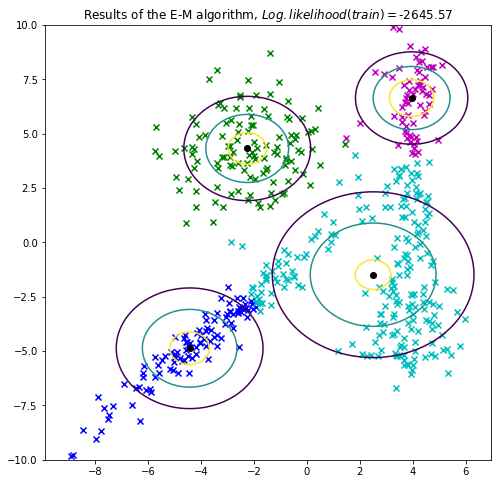

pi= [0.25157543 0.30569877 0.2564315  0.1862943 ] 
 
 mu= [[-2.03397743  4.1729834 ]
 [-3.05912587 -3.53186849]
 [ 3.98188316  3.85408931]
 [ 3.79932008 -3.76992751]] 
 
 Sigma= [array([[2.90618932, 0.20821221],
       [0.20821221, 2.75687343]]), array([[6.25579013, 6.06363504],
       [6.06363504, 6.1950282 ]]), array([[ 0.20798355,  0.27267492],
       [ 0.27267492, 11.8761229 ]]), array([[0.90978643, 0.05538855],
       [0.05538855, 1.92307834]])] 
 
 Log-likelihood(test)= -2409.257079442411


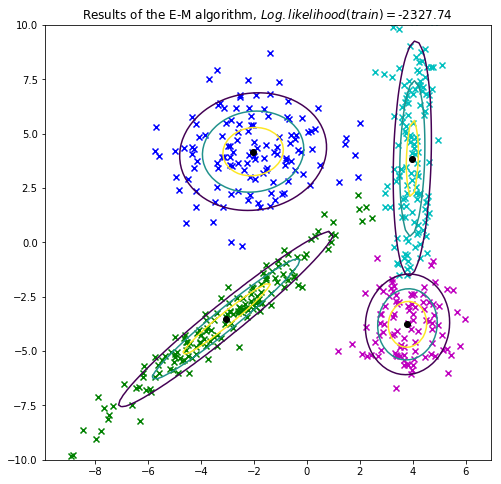

In [27]:
pi, mu, Sigma, Tau, log_like = E_M(X_train, 4, 0.01, Sigma_is_diag=True)
log_like_test = compute_log_likelihood(X_test, pi, mu, Sigma)
print('pi=',pi, '\n \n mu=', mu, '\n \n Sigma=', Sigma, '\n \n Log-likelihood(test)=', log_like_test)
plot_EM(X_train, Tau, mu, Sigma, log_like)

pi, mu, Sigma, Tau, log_like = E_M(X_train, 4, 0.01, Sigma_is_diag=False)
log_like_test = compute_log_likelihood(X_test, pi, mu, Sigma)
print('pi=',pi, '\n \n mu=', mu, '\n \n Sigma=', Sigma, '\n \n Log-likelihood(test)=', log_like_test)
plot_EM(X_train, Tau, mu, Sigma, log_like)

# Homework 4

## Computing the alpha-beta recursions:


Taking the derivations we presented in the Homework, we have:

$
\left\{
          \begin{array}{ll}
            \tilde{\alpha}(z_1) = \pi o(z_1), \; \forall t \in [\![1, T-1]\!], \; \tilde{\alpha} (z_{t+1})=\dfrac{o(z_{t+1}) \sum_{z_t} A_{z_{t+1}, z_{t}} \tilde{\alpha}(z_t)}{c_{t+1}}\\
            \\
            with \; c_{t+1} =  \sum_{z_{t+1}} o(z_{t+1}) \sum_{z_t} A_{z_{t+1}, z_{t}} \tilde{\alpha}(z_t)\\
            \\
            \tilde{\beta}(z_T) = 1, \; \forall t \in [\![1, T-1]\!], \; \tilde{\beta}(z_t)= \dfrac{\sum_{z_{t+1}} A_{z_{t+1}, z_{t}} o(z_{t+1}) \tilde{\beta}(z_{t+1})}{c_{t+1}} \\
          \end{array}
        \right.
$

$
\left\{
          \begin{array}{ll}
            p(z_t | x_{1:T})= \tilde{\alpha}(z_t)\tilde{\beta}(z_t)\\
            \\
            p(z_t, z_{t+1} | x_{1:T}) = \dfrac{A_{z_{t+1}, z_{t}}\tilde{\alpha}(z_t)\tilde{\beta}(z_{t+1})o(z_{t+1})}{c_{t+1}} \\
          \end{array}
        \right.
$

In the implementation, we will use the notations:

$\pi = \begin{pmatrix} p(z_1 = 1) \\ \vdots \\ p(z_1 = 4) \end{pmatrix} \quad ; \quad o_t = \begin{pmatrix} p(x_t | z_t = 1) \\ \vdots \\ p(x_t |z_t = 4) \end{pmatrix}$ given that $x_{t}|z_{t}=k \sim \mathcal{N}(x_{t}| \mu_k, \Sigma_k) \quad ; \quad A \in \mathbb{R}^{4 \times 4}$ with $A_{i,j} = p(z_t = i | z_{t-1} = j)$

In [18]:
def gaussian(x_t, mu_k, Sigma_k):
    
    """Returns the value of the density of probability for a given vector x_t"""
    
    return((1/(2*np.pi*np.sqrt(linalg.det(Sigma_k)))) * np.exp(-0.5*(x_t-mu_k).T.dot(linalg.inv(Sigma_k)).dot(x_t-mu_k)))

In [19]:
def compute_o_t(x_t, mu, Sigma):
    
    """Compute the vector o_t"""
    
    o_t = np.zeros((4,1))
    
    for k in range(4):
        
        o_t[k] = gaussian(x_t, mu[k], Sigma[k])
    
    return(o_t)

In [20]:
def compute_alpha_norm(X, pi, A, T, mu, Sigma):
    
    """Do the forward propagation and return the normalized alphas and the ct"""
    
    # Initialization
    
    alpha_norm = np.zeros((T, 4))
    c = np.zeros(T)
    o_1 = compute_o_t(X[0], mu, Sigma)
    alpha_norm[0] = (o_1*pi).flatten()
    
    for t in range(T-1):
        
        o = compute_o_t(X[t+1], mu, Sigma)
        A_times_alpha = np.dot(A, alpha_norm[t])
        c[t+1] = np.dot(o.T, A_times_alpha)
        alpha_norm[t+1] = o.flatten()*A_times_alpha / c[t+1]
    
    return(alpha_norm, c)

In [21]:
def compute_beta_norm(X, A, T, mu, Sigma, c):
    
    """Do the backward propagation and return the normalized betas"""
    
    beta_norm = np.zeros((T,4))
    beta_norm[T-1] = np.ones(4)
    
    for t in reversed(range(T-1)):
        
        o = compute_o_t(X[t+1], mu, Sigma).flatten()
        beta_norm[t] = np.dot(A.T, beta_norm[t+1]*o) / c[t+1]
    
    return(beta_norm)

In [22]:
def compute_smoothing(alpha_norm, beta_norm):
    
    """compute and return the probabilities p(z_t | x_{1:T})"""
    
    return(alpha_norm*beta_norm)

In [32]:
def compute_pair_marginals(X, A, T, mu, Sigma, c, alpha_norm, beta_norm):
    
    """compute and return the probabilities p(z_{t+1}, z_t | x_{1:T})"""
    
    pair_marginals = np.zeros((T-1,4,4))
    
    for t in range(T-1):
        
        o = compute_o_t(X[t+1], mu, Sigma).flatten()
        vector = beta_norm[t+1]*o / c[t+1]
        pair_marginals[t] = A*np.tensordot(vector, alpha_norm[t], axes=0)
    
    return(pair_marginals)

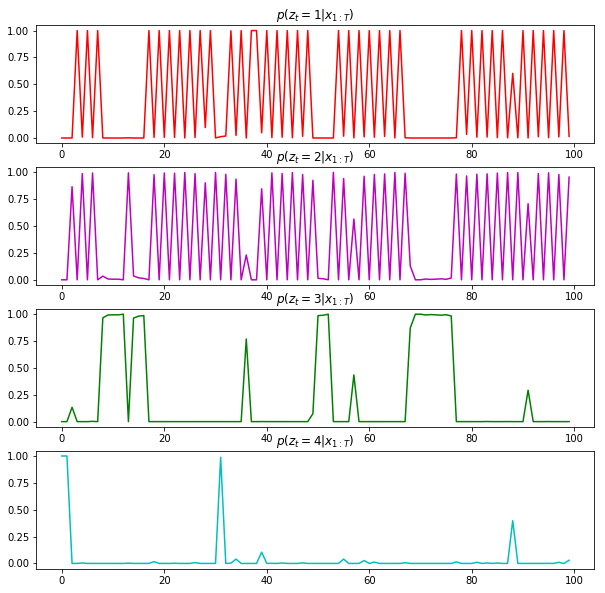

In [29]:
pi = 1/4 * np.ones((4,1))
A = 1/6*np.ones((4,4)) + 1/3*np.diag([1,1,1,1])
T = len(X_test)

mu= [[-2.0344, 4.1726 ],[3.9779, 3.7735],[3.8007, -3.7972],[-3.0620, -3.5345]] 
 
Sigma= [np.array([[2.9044, 0.2066],[0.2066, 2.7562]]),
        np.array([[0.2104, 0.2904],[0.2904, 12.2392]]),
        np.array([[0.9213,  0.0574],[0.0574, 1.8660]]),
        np.array([[6.2414, 6.0502],[6.0502, 6.1825]])]

alpha_norm, c = compute_alpha_norm(X_test, pi, A, T, mu, Sigma)
beta_norm = compute_beta_norm(X_test, A, T, mu, Sigma, c)
smoothing = compute_smoothing(alpha_norm, beta_norm)

time = [t for t in range(100)]
plt.figure(figsize=(10,10))
colors = ['r', 'm', 'g', 'c']

for k in range(4):
    
    num_plot = 410 + k+1
    plt.subplot(num_plot)
    plt.plot(time, smoothing[:100, k], color=colors[k])
    plt.title("$p(z_t = %s | x_{1:T})$" %str(k+1))

plt.show()

## E-M algorithm:

We have:

* $\forall \; k \; \in \; [\![1,4]\!], \hat{\pi}_k = p(z_1 =k |x)$
* $\forall \; i,j \; \in \; [\![1,4]\!]^2, \; \hat{A}_{ij} = \dfrac{\sum_{t=1}^{T-1} p(z_{t+1}=i, z_t=j |x)}{\sum_{t=1}^{T-1} p( z_t=j |x)}$
* $\forall \; k \; \in \; [\![1,4]\!], \; \hat{\mu}_k =  \dfrac{\sum_{t=1}^{T} x_t p(z_t=k |x)}{\sum_{t=1}^{T} p(z_t=k |x)} \quad ; \quad \hat{\Sigma}_k =  \dfrac{\sum_{t=1}^{T} (x_t - \hat{\mu}_k)(x_t - \hat{\mu}_k)^T p(z_t=k |x)}{\sum_{t=1}^{T} p(z_t=k |x)}$

The log-likelihood is $\log p_{\theta}(x) = \sum_{t=2}^T \log(c_t)$.

In [68]:
def compute_log_likelihood(c):
    
    """Compute and returns the log-likelihood"""
    
    return(np.sum(np.log(c[1:])))

In [106]:
def EM_algorithm(mu_init, Sigma_init, A_init, pi_init, X_train, X_test, epsilon):
    
    """Execute the EM algorithm and returns the final parameters,
    as well as the evolution of the log-likelihood during the training on the train and test data"""
    
    # Initialization
    
    X = X_train
    mu = mu_init
    Sigma = Sigma_init
    A = A_init
    pi = pi_init
    log_likelihood= []
    log_likelihood_test = []
    T = len(X)
    difference = math.inf
    
    alpha_norm, c = compute_alpha_norm(X, pi, A, T, mu, Sigma)
    _ , c_test = compute_alpha_norm(X_test, pi, A, T, mu, Sigma)
    log_like_t = compute_log_likelihood(c)
    log_like_t_test = compute_log_likelihood(c_test)
    log_likelihood.append(log_like_t)
    log_likelihood_test.append(log_like_t_test)
    
    # E-M algorithm
    
    while difference > epsilon:
        
        beta_norm = compute_beta_norm(X, A, T, mu, Sigma, c)
        smoothing = compute_smoothing(alpha_norm, beta_norm)
        pair_marginals = compute_pair_marginals(X, A, T, mu, Sigma, c, alpha_norm, beta_norm)
        pi = np.reshape(smoothing[0], (4,1))
        A_ = np.sum(pair_marginals, axis=0)
        A = A_ / np.sum(A_, axis=0)
        mu = np.dot(smoothing.T, X) / np.sum(smoothing, axis=0).reshape((4,1))
        sigma = compute_sigma(X, smoothing, mu)
        
        alpha_norm, c = compute_alpha_norm(X, pi, A, T, mu, Sigma)
        _ , c_test = compute_alpha_norm(X_test, pi, A, T, mu, Sigma)
        log_like_t1 = compute_log_likelihood(c)
        log_like_t_test = compute_log_likelihood(c_test)
        difference = np.abs(log_like_t1-log_like_t)
        log_like_t = log_like_t1
        log_likelihood.append(log_like_t)
        log_likelihood_test.append(log_like_t_test)
    
    return(pi, A, mu, Sigma, log_likelihood, log_likelihood_test)

In [107]:
pi_train, A_train, mu_train, Sigma_train, log_like_train, log_like_test= EM_algorithm(mu, Sigma, A, pi, X_train, X_test, 1e-7)

In [108]:
print('pi=',pi_train, '\n \n A=', A_train, '\n \n mu=', mu_train, '\n \n Sigma=', Sigma_train, '\n \n Log-likelihood(train)=', log_like_train[-1], '\n \n Log-likelihood(test)=', log_like_test[-1])

pi= [[2.49732991e-18]
 [9.58420944e-89]
 [3.43514297e-31]
 [1.00000000e+00]] 
 
 A= [[0.01573311 0.93018925 0.04184311 0.00668559]
 [0.87375739 0.02551808 0.04500327 0.07299448]
 [0.04738356 0.01106242 0.8790422  0.02019923]
 [0.06312595 0.03323025 0.03411142 0.9001207 ]] 
 
 mu= [[-1.95868304  4.1901814 ]
 [ 3.99409432  3.64959136]
 [ 3.78991099 -3.96430641]
 [-2.97205534 -3.4490553 ]] 
 
 Sigma= [array([[2.9044, 0.2066],
       [0.2066, 2.7562]]), array([[ 0.2104,  0.2904],
       [ 0.2904, 12.2392]]), array([[0.9213, 0.0574],
       [0.0574, 1.866 ]]), array([[6.2414, 6.0502],
       [6.0502, 6.1825]])] 
 
 Log-likelihood(train)= -1898.3653176579767 
 
 Log-likelihood(test)= -1958.5503172371375


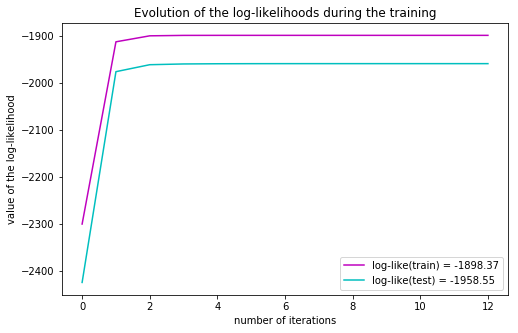

In [109]:
plt.figure(figsize=(8,5))
plt.plot([t for t in range(len(log_like_train))], log_like_train, label='log-like(train) = %s'  %str(np.round(log_like_train[-1],2)), color = 'm')
plt.plot([t for t in range(len(log_like_test))], log_like_test, label='log-like(test) = %s' %str(np.round(log_like_test[-1],2)), color='c')
plt.legend()
plt.xlabel('number of iterations')
plt.ylabel('value of the log-likelihood')
plt.title('Evolution of the log-likelihoods during the training')
plt.show()

## The Viterbi algorithm:

We have:

* $\gamma(z_1) = \log p(z_1) + \log p(x_1|z_1), \; \forall t \in [\![1, T-1]\!], \; \gamma(z_{t+1})= \log p(x_{t+1} |z_{t+1}) +  \max_{z_t} \Big( \log A_{z_{t+1}, z_{t}} + \gamma(z_t) \Big)$
* $memory(z_{t+1}) = \underset{z_t}{\mathrm{argmax}} \; \Big( \log A_{z_{t+1}, z_{t}} + \gamma(z_t) \Big)$
* $z_T^* = \underset{z_T}{\mathrm{argmax}} \gamma (z_T), \; \forall t \in [\![1, T-1]\!], z_t^* = memory(z_{t+1}^*)$

__________________________

$\textbf{ALGORITHM}:$

* $\textbf{Initialize}$ the variables $\gamma$ and $memory$
* $\textbf{Compute}$ $\gamma(z_1)$
* $\textbf{For $t \in [\![1, T-1]\!]$ compute}$ $\gamma(z_{t+1})$ and $memory(z_{t+1})$
* $\textbf{Initialize}$ the variable $z^*$
* $\textbf{Compute}$ $z_T^*$
* $\textbf{For $t \in \{T-1, ..., 1\}$ compute}$ $z_t^*$
* $\textbf{Return}$ $z^*$
___________________________

In [120]:
def Viterbi(X, pi, A, mu, Sigma):
    
    """Execute the Viterbi algorithm and returns the sequence of hidden state that maximizes the joint"""
    
    T = len(X)
    gamma = np.zeros((T,4))
    memory = np.zeros((T,4))
    
    gamma[0] = np.log(pi).flatten() + np.log(compute_o_t(X[0], mu, Sigma)).flatten()
    
    for t in range(T-1):
        
        log_o = np.log(compute_o_t(X[t+1], mu, Sigma)).flatten()
        gamma[t+1] = log_o + np.max(np.log(A) + gamma[t], axis=1)
        memory[t+1] = np.argmax(np.log(A) + gamma[t], axis=1)
    
    z_star = np.zeros(T)
    z_star[T-1] = np.argmax(gamma[T-1])
    
    for t in reversed(range(T-1)):

        z_star[t] = memory[t+1, int(z_star[t+1])]
    
    return(z_star)

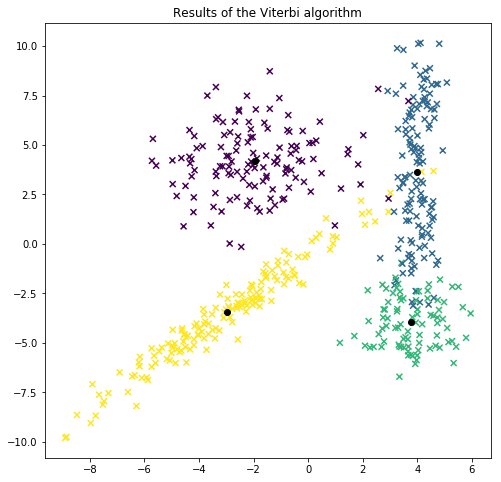

In [135]:
z_star = Viterbi(X_train, pi_train, A_train, mu_train, Sigma_train)

plt.figure (figsize=(8,8))
plt.scatter(X_train[:,0], X_train[:,1], c=z_star, marker='x')

for k in range(4):
    
    plt.scatter(mu_train[k,0], mu_train[k,1], marker='o', c='k')

plt.title("Results of the Viterbi algorithm")
plt.show()

## Question 9:

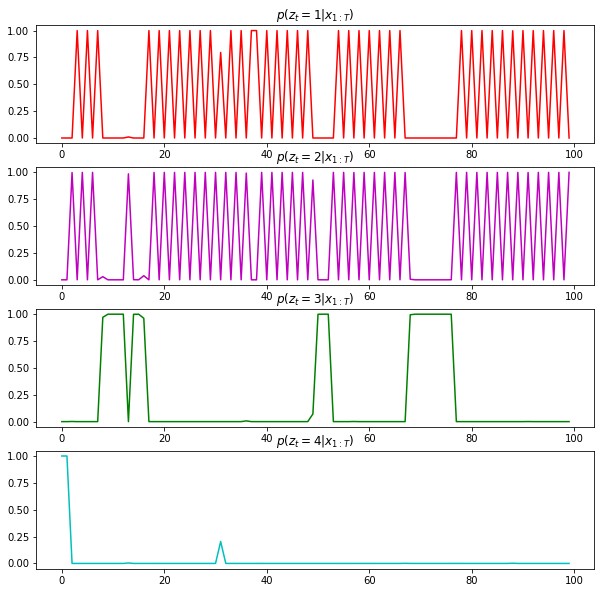

In [136]:
T = len(X_test)
alpha_norm, c = compute_alpha_norm(X_test, pi_train, A_train, T, mu_train, Sigma_train)
beta_norm = compute_beta_norm(X_test, A_train, T, mu_train, Sigma_train, c)
smoothing = compute_smoothing(alpha_norm, beta_norm)

time = [t for t in range(100)]
plt.figure(figsize=(10,10))
colors = ['r', 'm', 'g', 'c']

for k in range(4):
    
    num_plot = 410 + k+1
    plt.subplot(num_plot)
    plt.plot(time, smoothing[:100, k], color=colors[k])
    plt.title("$p(z_t = %s | x_{1:T})$" %str(k+1))

plt.show()

## Question 10:

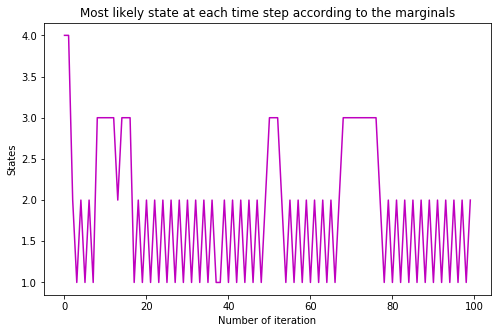

In [144]:
plt.figure(figsize=(8,5))
plt.plot(time, np.argmax(smoothing, axis=1)[:100] +1, c='m')
plt.xlabel('Number of iteration')
plt.ylabel('States')
plt.title('Most likely state at each time step according to the marginals')
plt.show()

## Question 11:

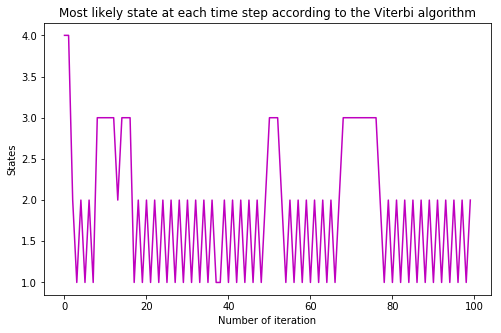

In [145]:
z_star = Viterbi(X_test, pi_train, A_train, mu_train, Sigma_train)

plt.figure(figsize=(8,5))
plt.plot(time, z_star[:100] +1, c='m')
plt.xlabel('Number of iteration')
plt.ylabel('States')
plt.title('Most likely state at each time step according to the Viterbi algorithm')
plt.show()